# Tabular Data Science - Final Task

In this task we'll explore how to improve <b>Pattern Mining</b> techniques within the data science pipeline. Specifically, we focus on Association Rule Mining and Frequent Pattern Mining to analyze flight delay data. This will help identify hidden patterns between flight features and delays. <br> <br>

Pattern mining, specifically Association Rule Mining, is a powerful method for uncovering relationships in large datasets, which we have in the project. To get into propotions, our original flight dataset has about <b>1M</b> records. For the US alone, in 3 years.<br><br>

By improving this aspect, we can:<br>
•	Identify hidden correlations and dependencies.<br>
•	Enhance the feature engineering process by introducing new variables based on the discovered patterns.<br>
•	Ultimately, help build more accurate predictive models for flight delays.


## <u>Desired Results</u>

•	Uncover Hidden Patterns: Find frequent patterns in flight data that directly correlate with delays (e.g., certain airlines, specific routes, or times of day with higher delays).<br>
•	 Generate Actionable Features: Develop new features derived from patterns (e.g., an "increased delay likelihood" feature for specific combinations of airline and airport).<br>
•	 Improve Model Performance: Enhance the predictive power of flight delay models by using the newly discovered features.


# Installations
Lets begin with imports & connecting to Drive.

In [1]:
# Installation of specific versions and libraries.
!pip install scikit-learn==1.2.0
!pip install xgboost==1.6.0
!pip install holidays
!pip install efficient_apriori
!pip install imbalanced-learn==0.10.0
!pip install mlxtend
%matplotlib inline


#imports
import shap
import xgboost as xgb
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import networkx as nx

from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy as sp
from scipy import stats
from scipy.stats import pearsonr

from xgboost import XGBRegressor

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

import holidays

from efficient_apriori import apriori

import warnings
warnings.filterwarnings("ignore")

  Using cached scikit_learn-1.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.0 which is incompatible.
  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.0
    Uninstalling scikit-learn-1.2.0:
  

/usr/local/lib/python3.11/dist-packages/holidays/deprecations/v1_incompatibility.py:40: FutureIncompatibilityWarning: 

This is a future version incompatibility warning from Holidays v0.67
to inform you about an upcoming change in our API versioning strategy that may affect your
project's dependencies. Starting from version 1.0 onwards, we will be following a loose form of
Semantic Versioning (SemVer, https://semver.org) to provide clearer communication regarding any
potential breaking changes.

This means that while we strive to maintain backward compatibility, there might be occasional
updates that introduce breaking changes to our API. To ensure the stability of your projects,
we highly recommend pinning the version of our API that you rely on. You can pin your current
holidays v0.x dependency (e.g., holidays==0.67) or limit it (e.g., holidays<1.0) in order to
avoid potentially unwanted upgrade to the version 1.0 when it's released (ETA 2025Q1-Q2).

If you have any questions or conc

Drive:

In [2]:

from google.colab import drive
drive.mount('/content/drive/')
#Source: https://www.kaggle.com/datasets/joelmott/flight-delays-dataset
#original dataset
dtf_1 = pd.read_csv("/content/drive/My Drive/ColabNotebooks/adc.csv", index_col='id')
#Source: https://www.kaggle.com/datasets/sriharshaeedala/airline-delay
dtf_2 = pd.read_csv("/content/drive/My Drive/ColabNotebooks/adc_2.csv", index_col='id')
#Source: https://www.transtats.bts.gov/ot_delay/ . From 1.2021 - 11.2024
dtf_3 = pd.read_csv("/content/drive/My Drive/ColabNotebooks/adc_3.csv", index_col='id')
#Source: https://www.kaggle.com/datasets/bordanova/2023-us-civil-flights-delay-meteo-and-aircraft
dtf_4 = pd.read_csv("/content/drive/My Drive/ColabNotebooks/adc_4.csv", index_col='id')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Now we need to impute missing numerical/categorial values, for each of the tables.

In [3]:
cols_1 = ["FL_DATE", "AIRLINE", "AIRLINE_DOT", "AIRLINE_CODE", "DOT_CODE", "FL_NUMBER", "ORIGIN", "ORIGIN_CITY", "DEST", "DEST_CITY", "CRS_DEP_TIME", "DEP_TIME", "DEP_DELAY", "TAXI_OUT", "WHEELS_OFF", "WHEELS_ON", "TAXI_IN", "CRS_ARR_TIME", "ARR_TIME", "ARR_DELAY", "CANCELLED", "CANCELLATION_CODE", "DIVERTED", "CRS_ELAPSED_TIME", "ELAPSED_TIME", "AIR_TIME", "DISTANCE", "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS", "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT"]
dtf_1 = dtf_1[cols_1]

df_processed_1 = dtf_1.copy()  # Keep original structure without one-hot encoding

# Reduce the dataset size for faster processing (use 5% of the data)
df_processed_1 = df_processed_1.sample(frac=0.05, random_state=42)  # Use 5% of the data

# Handle datetime column separately
if 'FL_DATE' in df_processed_1.columns:
    # Convert FL_DATE to datetime, coercing errors to NaT
    df_processed_1['FL_DATE'] = pd.to_datetime(df_processed_1['FL_DATE'], errors='coerce')

    # Check for any NaT values, and giving them default dates.
    if df_processed_1['FL_DATE'].isna().sum() > 0:
        print(f"Found {df_processed_1['FL_DATE'].isna().sum()} invalid date entries. Filling with a default date.")
        df_processed_1['FL_DATE'].fillna(pd.Timestamp('1900-01-01'), inplace=True)

    # Extract time fields
    df_processed_1['year'] = df_processed_1['FL_DATE'].dt.year
    df_processed_1['month'] = df_processed_1['FL_DATE'].dt.month
    df_processed_1['day'] = df_processed_1['FL_DATE'].dt.day
    df_processed_1['hour'] = df_processed_1['FL_DATE'].dt.hour
    df_processed_1['minute'] = df_processed_1['FL_DATE'].dt.minute
    df_processed_1['weekday'] = df_processed_1['FL_DATE'].dt.weekday

    # Drop the original datetime column
    df_processed_1.drop(columns=['FL_DATE'], inplace=True)


X_1 = df_processed_1.drop(['ARR_DELAY'], axis=1)
y_1 = df_processed_1['ARR_DELAY']

# Handle missing values in the target variable
y_imputer_1 = SimpleImputer(strategy='mean') # Imputations using the mean values
y_1 = y_imputer_1.fit_transform(y_1.values.reshape(-1, 1)).ravel()

# Separate categorical and numeric columns
categorical_cols_1 = X_1.select_dtypes(include=['object']).columns
numeric_cols_1 = X_1.select_dtypes(include=['number']).columns

# Impute missing values for categorical columns using the most frequent strategy
categorical_imputer_1 = SimpleImputer(strategy='most_frequent')

X_1[categorical_cols_1] = X_1[categorical_cols_1].fillna("MissingValue")
categorical_imputer_1 = SimpleImputer(strategy='most_frequent')
X_1[categorical_cols_1] = pd.DataFrame(
    categorical_imputer_1.fit_transform(X_1[categorical_cols_1]),
    columns=categorical_cols_1,
    index=X_1.index
)


# Impute missing values for numeric columns using the mean strategy
numeric_imputer_1 = SimpleImputer(strategy='mean')
X_1[numeric_cols_1] = pd.DataFrame(numeric_imputer_1.fit_transform(X_1[numeric_cols_1]), columns=numeric_cols_1, index=X_1.index)


################################adc_2################################################################
cols_2 = ["year", "month", "carrier", "carrier_name", "airport", "airport_name", "arr_flights", "arr_del15", "carrier_ct", "weather_ct", "nas_ct", "security_ct", "late_aircraft_ct", "arr_cancelled", "arr_diverted", "ARR_DELAY", "carrier_delay", "weather_delay", "nas_delay", "security_delay", "late_aircraft_delay"]
dtf_2 = dtf_2[cols_2]

df_processed_2 = dtf_2.copy()  # Keep original structure without one-hot encoding

df_processed_2 = df_processed_2.sample(frac=0.17, random_state=42)

X_2 = df_processed_2.drop(['ARR_DELAY'], axis=1)
y_2 = df_processed_2['ARR_DELAY']

# Handle missing values in the target variable
y_imputer_2 = SimpleImputer(strategy='mean') # Imputations using the mean values
y_2 = y_imputer_2.fit_transform(y_2.values.reshape(-1, 1)).ravel()

# Separate categorical and numeric columns
categorical_cols_2 = X_2.select_dtypes(include=['object']).columns
numeric_cols_2 = X_2.select_dtypes(include=['number']).columns

# Impute missing values for categorical columns using the most frequent strategy
categorical_imputer_2 = SimpleImputer(strategy='most_frequent')
X_2[categorical_cols_2] = categorical_imputer_2.fit_transform(X_2[categorical_cols_2])

# Impute missing values for numeric columns using the mean strategy
numeric_imputer_2 = SimpleImputer(strategy='mean')
X_2[numeric_cols_2] = numeric_imputer_2.fit_transform(X_2[numeric_cols_2])

################################adc_3################################################################

cols_3 = ["year", "month", "carrier", "carrier_name", "airport", "airport_name", "arr_flights", "arr_del15", "carrier_ct", "weather_ct", "nas_ct", "security_ct", "late_aircraft_ct", "arr_cancelled", "arr_diverted", "ARR_DELAY", "carrier_delay", "weather_delay", "nas_delay", "security_delay", "late_aircraft_delay"]
dtf_3 = dtf_3[cols_3]

df_processed_3 = dtf_3.copy()  # Keep original structure without one-hot encoding

df_processed_3 = df_processed_3.sample(frac=0.6, random_state=42)

X_3 = df_processed_3.drop(['ARR_DELAY'], axis=1)
y_3 = df_processed_3['ARR_DELAY']

# Handle missing values in the target variable
y_imputer_3 = SimpleImputer(strategy='mean') # Imputations using the mean values
y_3 = y_imputer_3.fit_transform(y_3.values.reshape(-1, 1)).ravel()

# Separate categorical and numeric columns
categorical_cols_3 = X_3.select_dtypes(include=['object']).columns
numeric_cols_3 = X_3.select_dtypes(include=['number']).columns

# Impute missing values for categorical columns using the most frequent strategy
categorical_imputer_3 = SimpleImputer(strategy='most_frequent')
X_3[categorical_cols_3] = categorical_imputer_3.fit_transform(X_3[categorical_cols_3])

# Impute missing values for numeric columns using the mean strategy
numeric_imputer_3 = SimpleImputer(strategy='mean')
X_3[numeric_cols_3] = numeric_imputer_3.fit_transform(X_3[numeric_cols_3])


################################adc_4################################################################

cols_4 = ["FlightDate", "Day_Of_Week", "Airline", "Tail_Number", "Cancelled", "Diverted", "Dep_Airport", "Dep_CityName", "DepTime_label", "Dep_Delay", "Dep_Delay_Tag", "Dep_Delay_Type", "Arr_Airport", "Arr_CityName", "ARR_DELAY", "Arr_Delay_Type", "Flight_Duration", "Distance_type", "Delay_Carrier", "Delay_Weather", "Delay_NAS", "Delay_Security", "Delay_LastAircraft"]
dtf_4 = dtf_4[cols_4]

# Process categorical data (one-hot encoding)
df_processed_4 = dtf_4.copy()  # Keep original structure without one-hot encoding

df_processed_4 = df_processed_4.sample(frac=0.5, random_state=42)

# Handle datetime column separately
if 'FlightDate' in df_processed_4.columns:
    # Convert FL_DATE to datetime, coercing errors to NaT
    df_processed_4['FlightDate'] = pd.to_datetime(df_processed_4['FlightDate'], errors='coerce')

    # Check for any NaT values, and giving them default dates.
    if df_processed_4['FlightDate'].isna().sum() > 0:
        print(f"Found {df_processed_4['FlightDate'].isna().sum()} invalid date entries. Filling with a default date.")
        df_processed_4['FlightDate'].fillna(pd.Timestamp('1900-01-01'), inplace=True)

    # Extract time fields
    df_processed_4['year'] = df_processed_4['FlightDate'].dt.year
    df_processed_4['month'] = df_processed_4['FlightDate'].dt.month
    df_processed_4['day'] = df_processed_4['FlightDate'].dt.day

    # Drop the original datetime column
    df_processed_4.drop(columns=['FlightDate'], inplace=True)

X_4 = df_processed_4.drop(['ARR_DELAY'], axis=1)
y_4 = df_processed_4['ARR_DELAY']

# Handle missing values in the target variable
y_imputer_4 = SimpleImputer(strategy='mean') # Imputations using the mean values
y_4 = y_imputer_4.fit_transform(y_4.values.reshape(-1, 1)).ravel()

# Separate categorical and numeric columns
categorical_cols_4 = X_4.select_dtypes(include=['object']).columns
numeric_cols_4 = X_4.select_dtypes(include=['number']).columns

# Impute missing values for categorical columns using the most frequent strategy
categorical_imputer_4 = SimpleImputer(strategy='most_frequent')
X_4[categorical_cols_4] = categorical_imputer_4.fit_transform(X_4[categorical_cols_4])

# Impute missing values for numeric columns using the mean strategy
numeric_imputer_4 = SimpleImputer(strategy='mean')
X_4[numeric_cols_4] = numeric_imputer_4.fit_transform(X_4[numeric_cols_4])

###########################################################################################

# Remove records where ARR_DELAY is null or less than 15 minutes
dtf_1 = dtf_1.dropna(subset=['ARR_DELAY'])
dtf_1 = dtf_1[dtf_1['ARR_DELAY'] >= 15]

dtf_2 = dtf_2.dropna(subset=['ARR_DELAY'])
dtf_2 = dtf_2[dtf_2['ARR_DELAY'] >= 15]

dtf_3 = dtf_3.dropna(subset=['ARR_DELAY'])
dtf_3 = dtf_3[dtf_3['ARR_DELAY'] >= 15]

dtf_4 = dtf_4.dropna(subset=['ARR_DELAY'])
dtf_4 = dtf_4[dtf_4['ARR_DELAY'] >= 15]



Found 32303 invalid date entries. Filling with a default date.


Default date for invalid dates is 01.01.1900 .

From each DTF, get the categorical values as preparation for our pattern mining.

In [4]:
def preprocess_for_mining(df):
    # Identify which dataset is being processed
    if set(["Dep_Delay", "ARR_DELAY"]).issubset(df.columns):
        # Dataset 1 or 4
        df['Dep_Delay_Bin'] = pd.cut(df['Dep_Delay'], bins=[-np.inf, 0, 15, 60, np.inf], labels=['No Delay', 'Short Delay', 'Moderate Delay', 'Severe Delay'])
        df['Arr_Delay_Bin'] = pd.cut(df['ARR_DELAY'], bins=[-np.inf, 0, 15, 60, np.inf], labels=['No Delay', 'Short Delay', 'Moderate Delay', 'Severe Delay'])
    elif "ARR_DELAY" in df.columns:
        # Dataset 2 or 3 (only arrival delay available)
        df['Arr_Delay_Bin'] = pd.cut(df['ARR_DELAY'], bins=[-np.inf, 0, 15, 60, np.inf], labels=['No Delay', 'Short Delay', 'Moderate Delay', 'Severe Delay'])

    # Define categorical columns based on dataset structure
    if set(cols_1).issubset(df.columns):
        categorical_cols = ["AIRLINE", "ORIGIN", "DEST"]
    elif set(cols_2).issubset(df.columns) or set(cols_3).issubset(df.columns):
        categorical_cols = ["carrier", "airport"]
    elif set(cols_4).issubset(df.columns):
        categorical_cols = ["Airline", "Dep_Airport", "Arr_Airport", "DepTime_label", "Arr_Delay_Type", "Dep_Delay_Type", "Distance_type"]

    # Ensure categorical columns exist in dataframe before processing
    categorical_cols = [col for col in categorical_cols if col in df.columns]

    # Convert categorical variables into strings
    df[categorical_cols] = df[categorical_cols].astype(str)

    # Include binning columns if created
    binning_cols = [col for col in ["Dep_Delay_Bin", "Arr_Delay_Bin"] if col in df.columns]

    # Create transaction-like format (list of lists)
    transactions = df[categorical_cols + binning_cols].apply(lambda row: row.dropna().tolist(), axis=1).tolist()

    return transactions


transactions_1 = preprocess_for_mining(dtf_1)
transactions_2 = preprocess_for_mining(dtf_2)
transactions_3 = preprocess_for_mining(dtf_3)
transactions_4 = preprocess_for_mining(dtf_4)


At first we "mined" all patterns, which gave us very low correlation values (0.19). We'll try to limit the min. support and confidence in order to get higher correlation.<br>
Another try, limiting min. values gave us 0.24. Lets try more.


In [5]:
def mine_frequent_patterns(transactions, min_support=0.01, min_confidence=0.5):
    """Finds frequent itemsets and association rules."""
    itemsets, rules = apriori(transactions, min_support=min_support, min_confidence=min_confidence)

    print(f"Frequent itemsets:\n{itemsets}\n")
    print(f"Association rules:")
    for rule in rules:
        print(rule)

    return itemsets, rules

# Run mining on each dataset
print("Dataset 1 Patterns:")
patterns_1, rules_1 = mine_frequent_patterns(transactions_1, min_support=0.05, min_confidence=0.6)

print("\nDataset 2 Patterns:")
patterns_2, rules_2 = mine_frequent_patterns(transactions_1, min_support=0.05, min_confidence=0.6)

print("\nDataset 3 Patterns:")
patterns_3, rules_3 = mine_frequent_patterns(transactions_1, min_support=0.05, min_confidence=0.6)

print("\nDataset 4 Patterns:")
patterns_4, rules_4 = mine_frequent_patterns(transactions_1, min_support=0.05, min_confidence=0.6)


Dataset 1 Patterns:
Frequent itemsets:
{1: {('Delta Air Lines Inc.',): 19532, ('Moderate Delay',): 119414, ('Southwest Airlines Co.',): 37852, ('Severe Delay',): 61393, ('ATL',): 15733, ('United Air Lines Inc.',): 16546, ('ORD',): 16201, ('LAS',): 10712, ('JetBlue Airways',): 10315, ('DFW',): 18073, ('MCO',): 10089, ('LAX',): 9888, ('American Airlines Inc.',): 26094, ('CLT',): 10914, ('SkyWest Airlines Inc.',): 18579, ('DEN',): 16812}, 2: {('ATL', 'Moderate Delay'): 10233, ('American Airlines Inc.', 'DFW'): 9908, ('American Airlines Inc.', 'Moderate Delay'): 16269, ('DEN', 'Moderate Delay'): 10861, ('DFW', 'Moderate Delay'): 11127, ('Delta Air Lines Inc.', 'Moderate Delay'): 12756, ('Moderate Delay', 'ORD'): 9700, ('Moderate Delay', 'SkyWest Airlines Inc.'): 10931, ('Moderate Delay', 'Southwest Airlines Co.'): 26864, ('Moderate Delay', 'United Air Lines Inc.'): 10101, ('Severe Delay', 'Southwest Airlines Co.'): 9537}}

Association rules:
{ATL} -> {Moderate Delay} (conf: 0.650, supp: 0.

# <u><b> Rules </b></u>
Lets mine for some association rules from our datasets using apriori methods.
From the 2nd model we see the airlines that have severe delays.
The 4th dataset didn't have any recorded delays (all of the records are with no delays), so this dataset isn't really useful. <br>
We can also see some frequent itemsets which can also provide us insight into
groups that appear together (singletons, dues and triplets).<br>
Association Rules can help identify relationships between groups of items and values, the confidence of being right items to be dragged(להיגרר) by the left element. The confidence tells us that % of the time it'll happen.<br>
Support (supp): This is the proportion of the dataset where the rule occurs. It tells you how frequently the antecedent and consequent co-occur in the dataset
<br>
Few Examples:
- {ATL} -> {Delta Air Lines Inc.} has a support of 0.047, meaning 4.7% of all records contain both ATL and Delta.<br>
- {ATL} -> {Delta Air Lines Inc.} with a confidence of 0.564 means that 56.4% of the time when a flight departs from ATL, it’s with Delta.
<br>
- ('ATL', 'Delta Air Lines Inc.', 'Moderate Delay') occurs 5,964 times. <br>
- ('ATL', 'Delta Air Lines Inc.') appears 8,880 times, which means there are 8,880 occurrences where both ATL (Hartsfield-Jackson Atlanta International) and Delta Air Lines Inc.<br>
- Conviction (conv): This is another measure of how strong the rule is. A higher conviction means a stronger association.<br>
- {ATL} -> {Delta Air Lines Inc.} has a conviction of 2.056, indicating that if ATL happens, it's more likely Delta will also occur.
<br><br>
### Conclusion:<br>
- There are strong associations between airlines (e.g., Delta Air Lines Inc., American Airlines Inc.) and delays (e.g., Moderate Delay, Severe Delay).
- Airport and Airline Pairings: Specific airports and airlines show high frequencies together. {ATL, Delta Air Lines Inc.} shows that flights from ATL by Delta are frequent, and they often have delays (e.g., Moderate Delay, Severe Delay).
- {Moderate Delay} -> {Southwest Airlines Co.} has a confidence of 0.960, which means Southwest flights are highly associated with moderate delays

Lets go with mapping all of that!

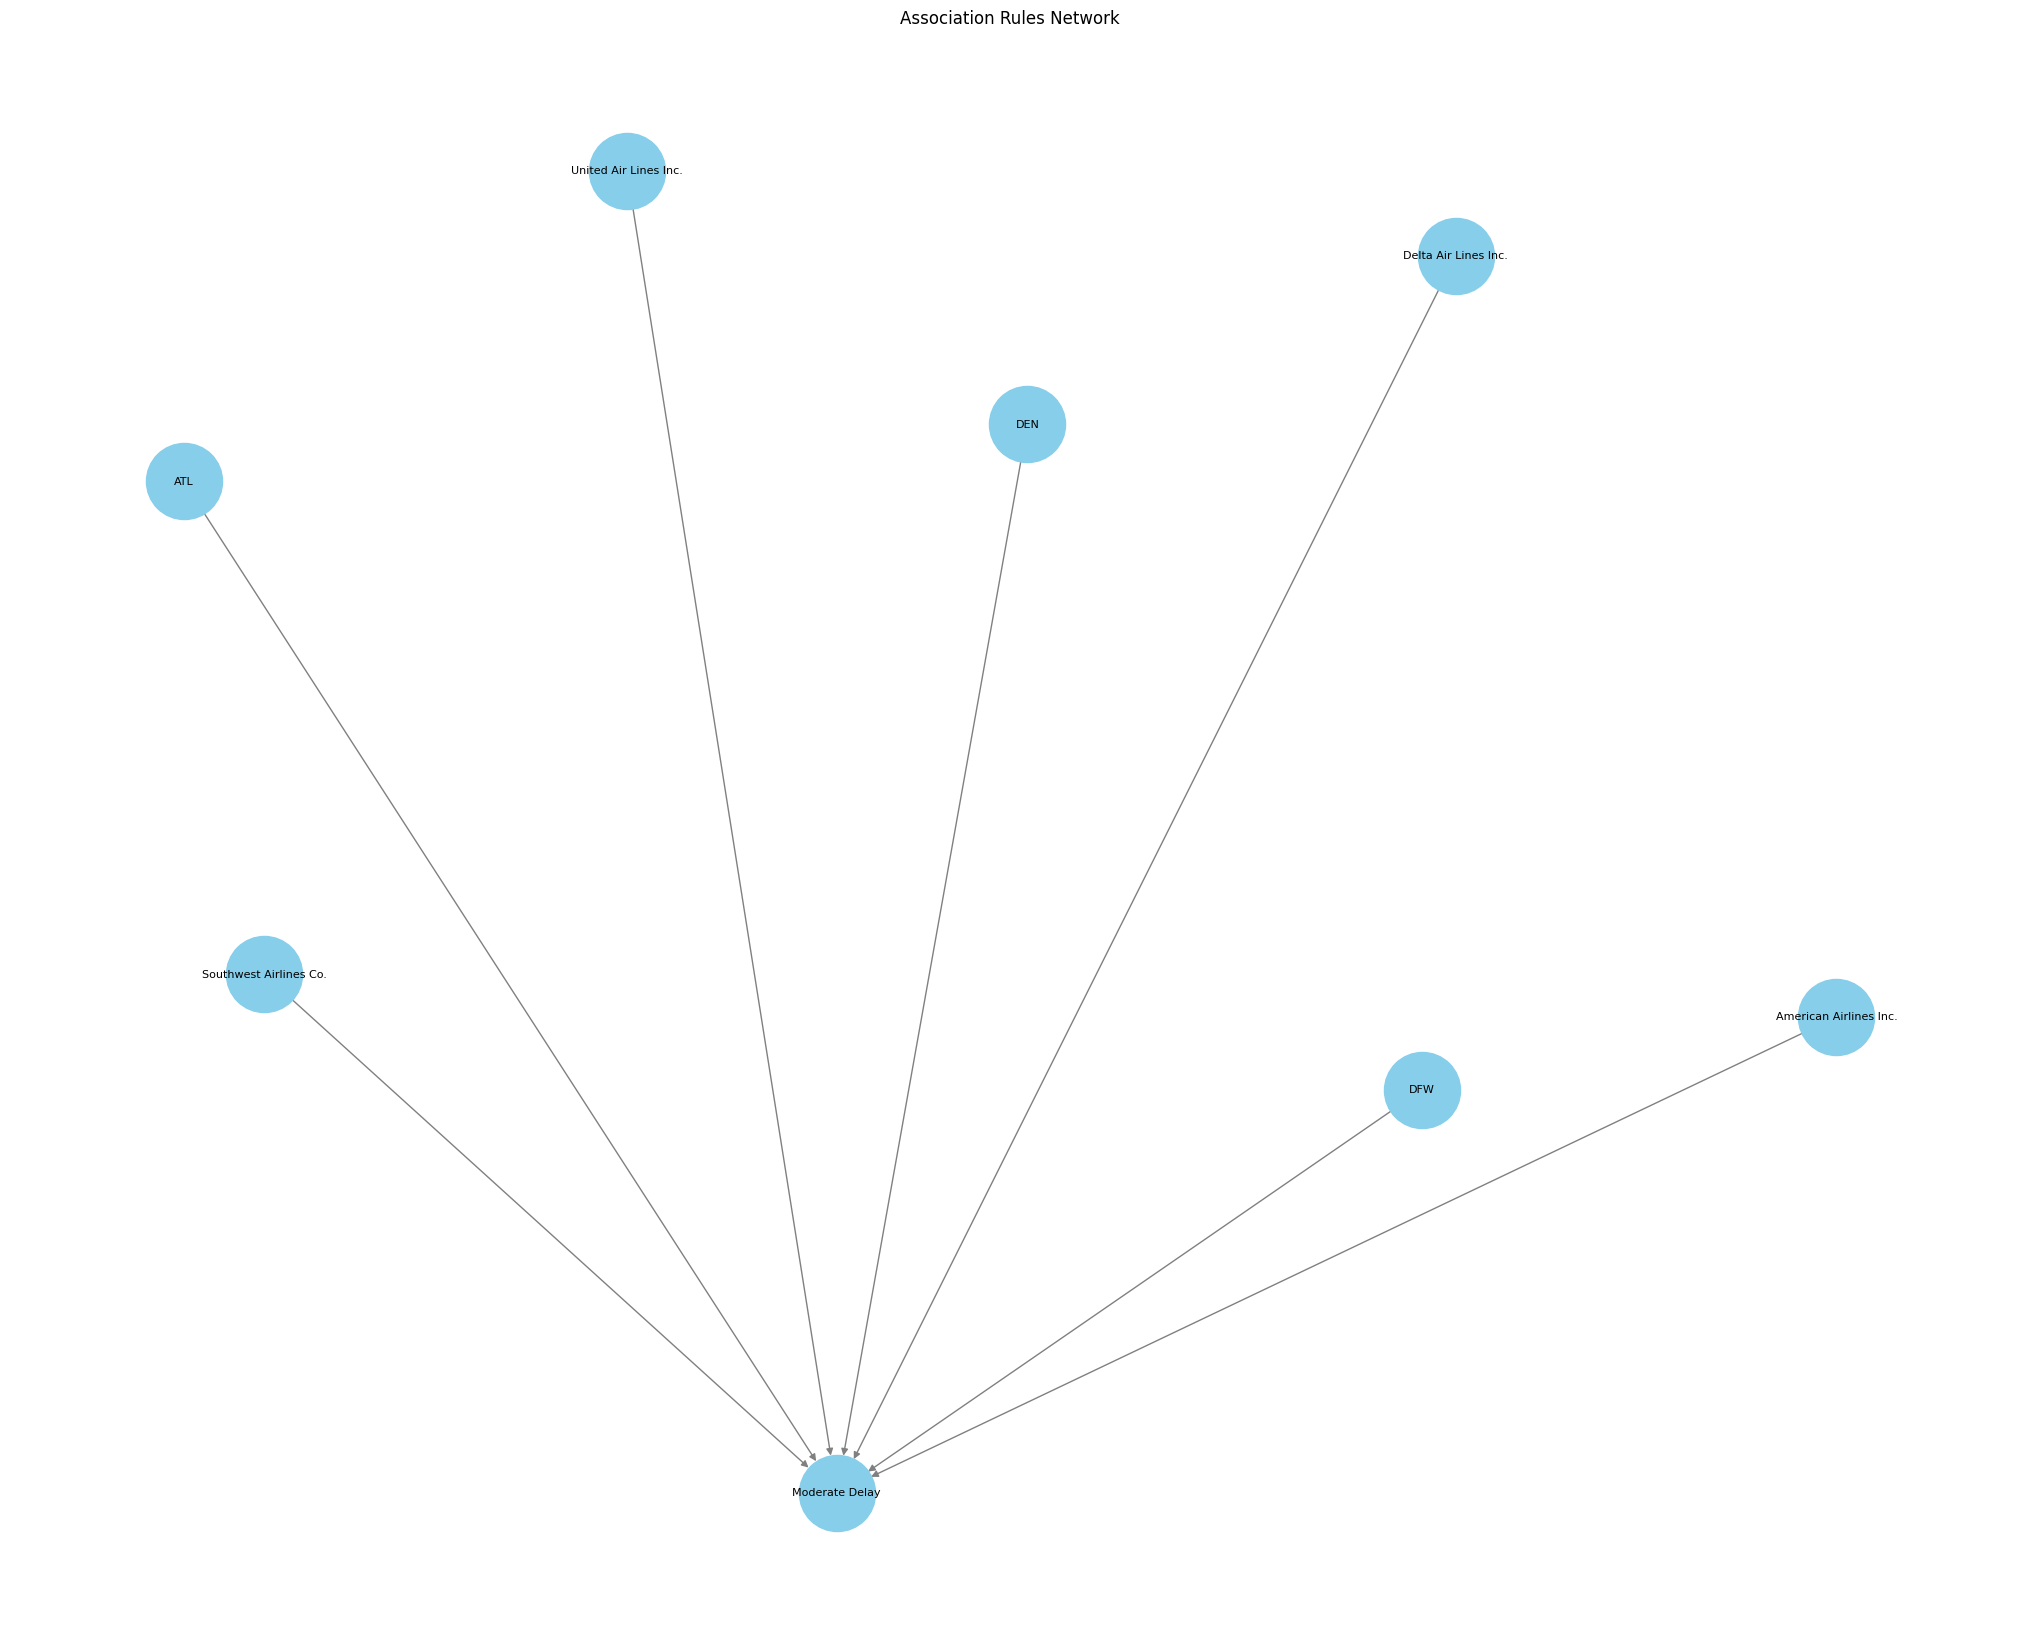

In [6]:

def visualize_rules(rules):
    G = nx.DiGraph()
    for rule in rules:
        lhs, rhs = list(rule.lhs), list(rule.rhs)
        for item in lhs:
            G.add_edge(item, rhs[0], weight=rule.confidence)

    plt.figure(figsize=(20, 16))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=3000, font_size=8)
    plt.title("Association Rules Network")
    plt.show()

# Visualize rules from Dataset 1
visualize_rules(rules_1)


# <u><b>Training Models</u></b>
Lets train using linear regression, and then using XGB.

Lets find the importance of each plot for each set.

In [7]:

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=42)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size=0.2, random_state=42)


# Apply One-Hot Encoding for categorical variables in both train and test sets
X_train_1 = pd.get_dummies(X_train_1, drop_first=True)
X_test_1 = pd.get_dummies(X_test_1, drop_first=True)

X_train_2 = pd.get_dummies(X_train_2, drop_first=True)
X_test_2 = pd.get_dummies(X_test_2, drop_first=True)

X_train_3 = pd.get_dummies(X_train_3, drop_first=True)
X_test_3 = pd.get_dummies(X_test_3, drop_first=True)

X_train_4 = pd.get_dummies(X_train_4, drop_first=True)
X_test_4 = pd.get_dummies(X_test_4, drop_first=True)

# Ensure both training and test sets have the same columns
X_train_1, X_test_1 = X_train_1.align(X_test_1, join='left', axis=1, fill_value=0)
X_train_2, X_test_2 = X_train_2.align(X_test_2, join='left', axis=1, fill_value=0)
X_train_3, X_test_3 = X_train_3.align(X_test_3, join='left', axis=1, fill_value=0)
X_train_4, X_test_4 = X_train_4.align(X_test_4, join='left', axis=1, fill_value=0)

model_1 = LinearRegression().fit(X_train_1, y_train_1)
model_2 = LinearRegression().fit(X_train_2, y_train_2)
model_3 = LinearRegression().fit(X_train_3, y_train_3)
model_4 = LinearRegression().fit(X_train_4, y_train_4)


In [8]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"R^2 Score: {r2_score(y_test, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")

print("Model 1 Performance:")
evaluate_model(model_1, X_test_1, y_test_1)

print("\nModel 2 Performance:")
evaluate_model(model_2, X_test_2, y_test_2)

print("\nModel 3 Performance:")
evaluate_model(model_3, X_test_3, y_test_3)

print("\nModel 4 Performance:")
evaluate_model(model_4, X_test_4, y_test_4)


Model 1 Performance:
R^2 Score: 0.9792
MAE: 4.38

Model 2 Performance:
R^2 Score: 1.0000
MAE: 0.00

Model 3 Performance:
R^2 Score: 1.0000
MAE: 0.15

Model 4 Performance:
R^2 Score: 1.0000
MAE: 0.00


Model 4 is a no brainer, all of the records have no delays.<br>
Model 1 is the most informative and we get a R^2 score similar to the past runs in past exercises, however due to amount of different records & delays, it's understandable that the model with have a higher MAE than the rest.<br>
Note that this model was used in the past as well.<br>
Model 2 gets a perfect R^2 score with 0 mean abs. error,
and for the 3rd model we get a small MAE.<br><br>
But we're here for patterns.<br>
Earlier we demonstrated the use of Apriori algorithm, we also have FP Growth.


In [9]:
encoder_1 = TransactionEncoder()
encoded_data_1 = encoder_1.fit_transform(transactions_1)
df_encoded_1 = pd.DataFrame(encoded_data_1, columns=encoder_1.columns_)

encoder_2 = TransactionEncoder()
encoded_data_2 = encoder_2.fit_transform(transactions_2)
df_encoded_2 = pd.DataFrame(encoded_data_2, columns=encoder_2.columns_)

encoder_3 = TransactionEncoder()
encoded_data_3 = encoder_3.fit_transform(transactions_3)
df_encoded_3 = pd.DataFrame(encoded_data_3, columns=encoder_3.columns_)

encoder_4 = TransactionEncoder()
encoded_data_4 = encoder_4.fit_transform(transactions_4)
df_encoded_4 = pd.DataFrame(encoded_data_4, columns=encoder_4.columns_)


frequent_itemsets_1 = fpgrowth(df_encoded_1, min_support=0.1, use_colnames=True)
print("1 - Frequent Itemsets:")
print(frequent_itemsets_1)

frequent_itemsets_2 = fpgrowth(df_encoded_2, min_support=0.1, use_colnames=True)
print("2 - Frequent Itemsets:")
print(frequent_itemsets_2)

frequent_itemsets_3 = fpgrowth(df_encoded_3, min_support=0.1, use_colnames=True)
print("3 - Frequent Itemsets:")
print(frequent_itemsets_3)

frequent_itemsets_4 = fpgrowth(df_encoded_4, min_support=0.1, use_colnames=True)
print("4 - Frequent Itemsets:")
print(frequent_itemsets_4)


1 - Frequent Itemsets:
    support                                  itemsets
0  0.637650                          (Moderate Delay)
1  0.104297                    (Delta Air Lines Inc.)
2  0.327828                            (Severe Delay)
3  0.202123                  (Southwest Airlines Co.)
4  0.139337                  (American Airlines Inc.)
5  0.143449  (Moderate Delay, Southwest Airlines Co.)
2 - Frequent Itemsets:
    support            itemsets
0  0.959007      (Severe Delay)
1  0.149243                (OO)
2  0.143879  (Severe Delay, OO)
3 - Frequent Itemsets:
    support            itemsets
0  0.957709      (Severe Delay)
1  0.125641                (OO)
2  0.121838  (Severe Delay, OO)
4 - Frequent Itemsets:
Empty DataFrame
Columns: [support, itemsets]
Index: []


In [10]:
# Convert rules into a dictionary for easy lookup
def extract_pattern_scores(rules):
    pattern_dict = {}
    for rule in rules:
        antecedent = frozenset(rule.lhs)  # Convert to set for easier matching
        confidence = rule.confidence
        pattern_dict[antecedent] = confidence
    return pattern_dict

# Create pattern dictionaries for each dataset
pattern_dict_1 = extract_pattern_scores(rules_1)
pattern_dict_2 = extract_pattern_scores(rules_2)
pattern_dict_3 = extract_pattern_scores(rules_3)
pattern_dict_4 = extract_pattern_scores(rules_4)


Generate a new column in the datasets to assign <u>confidence score</u> to each row, based on whether it's matching a discovered pattern.<br>
And then, verify it provides some information.

In [11]:
# Function to check if a row matches any discovered pattern
def assign_pattern_score(row, pattern_dict):
    for pattern, confidence in pattern_dict.items():
        if pattern.issubset(frozenset(row)):  # Check if pattern is in the row
            return confidence
    return 0  # Default score

df_processed_1['Pattern_Found'] = df_processed_1.apply(lambda row: 1 if assign_pattern_score(row, pattern_dict_1) > 0 else 0, axis=1)
df_processed_2['Pattern_Found'] = df_processed_2.apply(lambda row: 1 if assign_pattern_score(row, pattern_dict_2) > 0 else 0, axis=1)
df_processed_3['Pattern_Found'] = df_processed_3.apply(lambda row: 1 if assign_pattern_score(row, pattern_dict_3) > 0 else 0, axis=1)
df_processed_4['Pattern_Found'] = df_processed_4.apply(lambda row: 1 if assign_pattern_score(row, pattern_dict_4) > 0 else 0, axis=1)

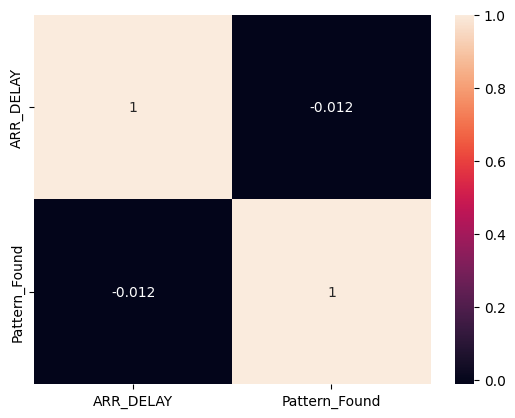

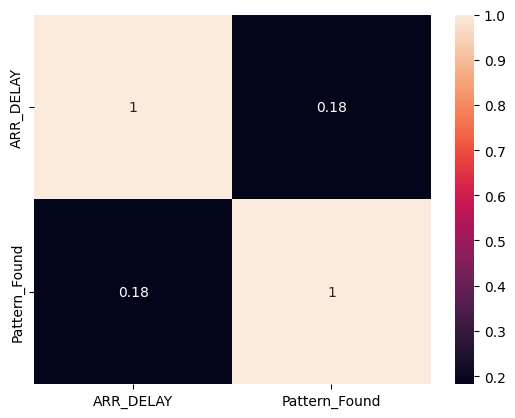

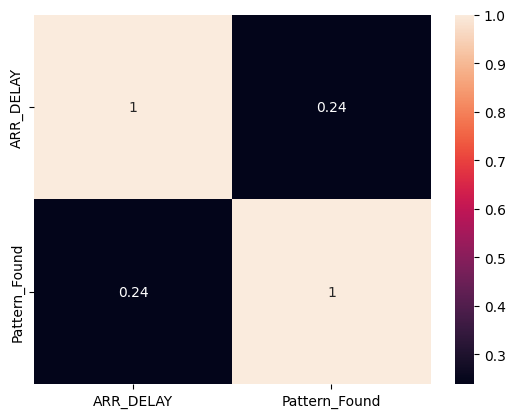

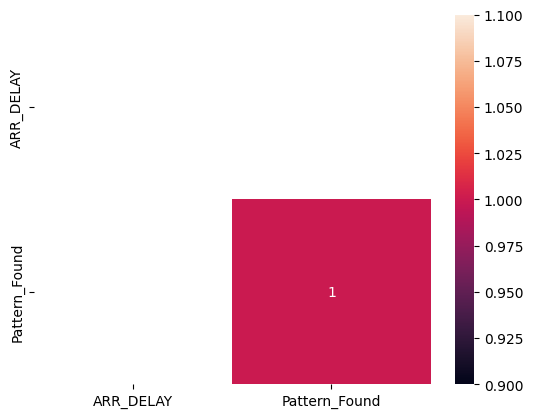

In [12]:
sns.heatmap(df_processed_1[['ARR_DELAY', 'Pattern_Found']].corr(), annot=True)
plt.show()

sns.heatmap(df_processed_2[['ARR_DELAY', 'Pattern_Found']].corr(), annot=True)
plt.show()

sns.heatmap(df_processed_3[['ARR_DELAY', 'Pattern_Found']].corr(), annot=True)
plt.show()

sns.heatmap(df_processed_4[['ARR_DELAY', 'Pattern_Found']].corr(), annot=True)
plt.show()

Note that the last dataset was also zeroed in values of arrival delays, so it provides nothing.<br>
But we do have some scores, the scores aren't high though. The highest one is 0.24.<br><br>

# Here we go again
Train models, preprocess for mining, and now - we get <u><b> FEATURE IMPORTANCE </u></b>

In [13]:
#original dataset
dtf_1 = pd.read_csv("/content/drive/My Drive/ColabNotebooks/adc.csv", index_col='id')
#Source: https://www.kaggle.com/datasets/sriharshaeedala/airline-delay
dtf_2 = pd.read_csv("/content/drive/My Drive/ColabNotebooks/adc_2.csv", index_col='id')
#Source: https://www.transtats.bts.gov/ot_delay/ . From 1.2021 - 11.2024
dtf_3 = pd.read_csv("/content/drive/My Drive/ColabNotebooks/adc_3.csv", index_col='id')
#Source: https://www.kaggle.com/datasets/bordanova/2023-us-civil-flights-delay-meteo-and-aircraft
dtf_4 = pd.read_csv("/content/drive/My Drive/ColabNotebooks/adc_4.csv", index_col='id')

cols_1 = ["FL_DATE", "AIRLINE", "AIRLINE_DOT", "AIRLINE_CODE", "DOT_CODE", "FL_NUMBER", "ORIGIN", "ORIGIN_CITY", "DEST", "DEST_CITY", "CRS_DEP_TIME", "DEP_TIME", "DEP_DELAY", "TAXI_OUT", "WHEELS_OFF", "WHEELS_ON", "TAXI_IN", "CRS_ARR_TIME", "ARR_TIME", "ARR_DELAY", "CANCELLED", "CANCELLATION_CODE", "DIVERTED", "CRS_ELAPSED_TIME", "ELAPSED_TIME", "AIR_TIME", "DISTANCE", "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS", "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT"]
dtf_1 = dtf_1[cols_1]

df_processed_1 = dtf_1.copy()  # Keep original structure without one-hot encoding

# Reduce the dataset size for faster processing (use 5% of the data)
df_processed_1 = df_processed_1.sample(frac=0.05, random_state=42)  # Use 5% of the data

# Handle datetime column separately
if 'FL_DATE' in df_processed_1.columns:
    # Convert FL_DATE to datetime, coercing errors to NaT
    df_processed_1['FL_DATE'] = pd.to_datetime(df_processed_1['FL_DATE'], errors='coerce')

    # Check for any NaT values, and giving them default dates.
    if df_processed_1['FL_DATE'].isna().sum() > 0:
        print(f"Found {df_processed_1['FL_DATE'].isna().sum()} invalid date entries. Filling with a default date.")
        df_processed_1['FL_DATE'].fillna(pd.Timestamp('1900-01-01'), inplace=True)

    # Extract time fields
    df_processed_1['year'] = df_processed_1['FL_DATE'].dt.year
    df_processed_1['month'] = df_processed_1['FL_DATE'].dt.month
    df_processed_1['day'] = df_processed_1['FL_DATE'].dt.day
    df_processed_1['hour'] = df_processed_1['FL_DATE'].dt.hour
    df_processed_1['minute'] = df_processed_1['FL_DATE'].dt.minute
    df_processed_1['weekday'] = df_processed_1['FL_DATE'].dt.weekday

    # Drop the original datetime column
    df_processed_1.drop(columns=['FL_DATE'], inplace=True)


X_1 = df_processed_1.drop(['ARR_DELAY'], axis=1)
y_1 = df_processed_1['ARR_DELAY']

# Handle missing values in the target variable
y_imputer_1 = SimpleImputer(strategy='mean') # Imputations using the mean values
y_1 = y_imputer_1.fit_transform(y_1.values.reshape(-1, 1)).ravel()

# Separate categorical and numeric columns
categorical_cols_1 = X_1.select_dtypes(include=['object']).columns
numeric_cols_1 = X_1.select_dtypes(include=['number']).columns

# Impute missing values for categorical columns using the most frequent strategy
categorical_imputer_1 = SimpleImputer(strategy='most_frequent')

X_1[categorical_cols_1] = X_1[categorical_cols_1].fillna("MissingValue")
categorical_imputer_1 = SimpleImputer(strategy='most_frequent')
X_1[categorical_cols_1] = pd.DataFrame(
    categorical_imputer_1.fit_transform(X_1[categorical_cols_1]),
    columns=categorical_cols_1,
    index=X_1.index
)


# Impute missing values for numeric columns using the mean strategy
numeric_imputer_1 = SimpleImputer(strategy='mean')
X_1[numeric_cols_1] = pd.DataFrame(numeric_imputer_1.fit_transform(X_1[numeric_cols_1]), columns=numeric_cols_1, index=X_1.index)


################################adc_2################################################################
cols_2 = ["year", "month", "carrier", "carrier_name", "airport", "airport_name", "arr_flights", "arr_del15", "carrier_ct", "weather_ct", "nas_ct", "security_ct", "late_aircraft_ct", "arr_cancelled", "arr_diverted", "ARR_DELAY", "carrier_delay", "weather_delay", "nas_delay", "security_delay", "late_aircraft_delay"]
dtf_2 = dtf_2[cols_2]

df_processed_2 = dtf_2.copy()  # Keep original structure without one-hot encoding

df_processed_2 = df_processed_2.sample(frac=0.17, random_state=42)

X_2 = df_processed_2.drop(['ARR_DELAY'], axis=1)
y_2 = df_processed_2['ARR_DELAY']

# Handle missing values in the target variable
y_imputer_2 = SimpleImputer(strategy='mean') # Imputations using the mean values
y_2 = y_imputer_2.fit_transform(y_2.values.reshape(-1, 1)).ravel()

# Separate categorical and numeric columns
categorical_cols_2 = X_2.select_dtypes(include=['object']).columns
numeric_cols_2 = X_2.select_dtypes(include=['number']).columns

# Impute missing values for categorical columns using the most frequent strategy
categorical_imputer_2 = SimpleImputer(strategy='most_frequent')
X_2[categorical_cols_2] = categorical_imputer_2.fit_transform(X_2[categorical_cols_2])

# Impute missing values for numeric columns using the mean strategy
numeric_imputer_2 = SimpleImputer(strategy='mean')
X_2[numeric_cols_2] = numeric_imputer_2.fit_transform(X_2[numeric_cols_2])

################################adc_3################################################################

cols_3 = ["year", "month", "carrier", "carrier_name", "airport", "airport_name", "arr_flights", "arr_del15", "carrier_ct", "weather_ct", "nas_ct", "security_ct", "late_aircraft_ct", "arr_cancelled", "arr_diverted", "ARR_DELAY", "carrier_delay", "weather_delay", "nas_delay", "security_delay", "late_aircraft_delay"]
dtf_3 = dtf_3[cols_3]

df_processed_3 = dtf_3.copy()  # Keep original structure without one-hot encoding

df_processed_3 = df_processed_3.sample(frac=0.6, random_state=42)

X_3 = df_processed_3.drop(['ARR_DELAY'], axis=1)
y_3 = df_processed_3['ARR_DELAY']

# Handle missing values in the target variable
y_imputer_3 = SimpleImputer(strategy='mean') # Imputations using the mean values
y_3 = y_imputer_3.fit_transform(y_3.values.reshape(-1, 1)).ravel()

# Separate categorical and numeric columns
categorical_cols_3 = X_3.select_dtypes(include=['object']).columns
numeric_cols_3 = X_3.select_dtypes(include=['number']).columns

# Impute missing values for categorical columns using the most frequent strategy
categorical_imputer_3 = SimpleImputer(strategy='most_frequent')
X_3[categorical_cols_3] = categorical_imputer_3.fit_transform(X_3[categorical_cols_3])

# Impute missing values for numeric columns using the mean strategy
numeric_imputer_3 = SimpleImputer(strategy='mean')
X_3[numeric_cols_3] = numeric_imputer_3.fit_transform(X_3[numeric_cols_3])


################################adc_4################################################################

cols_4 = ["FlightDate", "Day_Of_Week", "Airline", "Tail_Number", "Cancelled", "Diverted", "Dep_Airport", "Dep_CityName", "DepTime_label", "Dep_Delay", "Dep_Delay_Tag", "Dep_Delay_Type", "Arr_Airport", "Arr_CityName", "ARR_DELAY", "Arr_Delay_Type", "Flight_Duration", "Distance_type", "Delay_Carrier", "Delay_Weather", "Delay_NAS", "Delay_Security", "Delay_LastAircraft"]
dtf_4 = dtf_4[cols_4]

# Process categorical data (one-hot encoding)
df_processed_4 = dtf_4.copy()  # Keep original structure without one-hot encoding

df_processed_4 = df_processed_4.sample(frac=0.5, random_state=42)

# Handle datetime column separately
if 'FlightDate' in df_processed_4.columns:
    # Convert FL_DATE to datetime, coercing errors to NaT
    df_processed_4['FlightDate'] = pd.to_datetime(df_processed_4['FlightDate'], errors='coerce')

    # Check for any NaT values, and giving them default dates.
    if df_processed_4['FlightDate'].isna().sum() > 0:
        print(f"Found {df_processed_4['FlightDate'].isna().sum()} invalid date entries. Filling with a default date.")
        df_processed_4['FlightDate'].fillna(pd.Timestamp('1900-01-01'), inplace=True)

    # Extract time fields
    df_processed_4['year'] = df_processed_4['FlightDate'].dt.year
    df_processed_4['month'] = df_processed_4['FlightDate'].dt.month
    df_processed_4['day'] = df_processed_4['FlightDate'].dt.day

    # Drop the original datetime column
    df_processed_4.drop(columns=['FlightDate'], inplace=True)

X_4 = df_processed_4.drop(['ARR_DELAY'], axis=1)
y_4 = df_processed_4['ARR_DELAY']

# Handle missing values in the target variable
y_imputer_4 = SimpleImputer(strategy='mean') # Imputations using the mean values
y_4 = y_imputer_4.fit_transform(y_4.values.reshape(-1, 1)).ravel()

# Separate categorical and numeric columns
categorical_cols_4 = X_4.select_dtypes(include=['object']).columns
numeric_cols_4 = X_4.select_dtypes(include=['number']).columns

# Impute missing values for categorical columns using the most frequent strategy
categorical_imputer_4 = SimpleImputer(strategy='most_frequent')
X_4[categorical_cols_4] = categorical_imputer_4.fit_transform(X_4[categorical_cols_4])

# Impute missing values for numeric columns using the mean strategy
numeric_imputer_4 = SimpleImputer(strategy='mean')
X_4[numeric_cols_4] = numeric_imputer_4.fit_transform(X_4[numeric_cols_4])

###########################################################################################

# Remove records where ARR_DELAY is null or less than 15 minutes
dtf_1 = dtf_1.dropna(subset=['ARR_DELAY'])
dtf_1 = dtf_1[dtf_1['ARR_DELAY'] >= 15]

dtf_2 = dtf_2.dropna(subset=['ARR_DELAY'])
dtf_2 = dtf_2[dtf_2['ARR_DELAY'] >= 15]

dtf_3 = dtf_3.dropna(subset=['ARR_DELAY'])
dtf_3 = dtf_3[dtf_3['ARR_DELAY'] >= 15]

dtf_4 = dtf_4.dropna(subset=['ARR_DELAY'])
dtf_4 = dtf_4[dtf_4['ARR_DELAY'] >= 15]


def preprocess_for_mining(df):
    # Identify which dataset is being processed
    if set(["Dep_Delay", "ARR_DELAY"]).issubset(df.columns):
        # Dataset 1 or 4
        df['Dep_Delay_Bin'] = pd.cut(df['Dep_Delay'], bins=[-np.inf, 0, 15, 60, np.inf], labels=['No Delay', 'Short Delay', 'Moderate Delay', 'Severe Delay'])
        df['Arr_Delay_Bin'] = pd.cut(df['ARR_DELAY'], bins=[-np.inf, 0, 15, 60, np.inf], labels=['No Delay', 'Short Delay', 'Moderate Delay', 'Severe Delay'])
    elif "ARR_DELAY" in df.columns:
        # Dataset 2 or 3 (only arrival delay available)
        df['Arr_Delay_Bin'] = pd.cut(df['ARR_DELAY'], bins=[-np.inf, 0, 15, 60, np.inf], labels=['No Delay', 'Short Delay', 'Moderate Delay', 'Severe Delay'])

    # Define categorical columns based on dataset structure
    if set(cols_1).issubset(df.columns):
        categorical_cols = ["AIRLINE", "ORIGIN", "DEST"]
    elif set(cols_2).issubset(df.columns) or set(cols_3).issubset(df.columns):
        categorical_cols = ["carrier", "airport"]
    elif set(cols_4).issubset(df.columns):
        categorical_cols = ["Airline", "Dep_Airport", "Arr_Airport", "DepTime_label", "Arr_Delay_Type", "Dep_Delay_Type", "Distance_type"]

    # Ensure categorical columns exist in dataframe before processing
    categorical_cols = [col for col in categorical_cols if col in df.columns]

    # Convert categorical variables into strings
    df[categorical_cols] = df[categorical_cols].astype(str)

    # Include binning columns if created
    binning_cols = [col for col in ["Dep_Delay_Bin", "Arr_Delay_Bin"] if col in df.columns]

    # Create transaction-like format (list of lists)
    transactions = df[categorical_cols + binning_cols].apply(lambda row: row.dropna().tolist(), axis=1).tolist()

    return transactions


transactions_1 = preprocess_for_mining(dtf_1)
transactions_2 = preprocess_for_mining(dtf_2)
transactions_3 = preprocess_for_mining(dtf_3)
transactions_4 = preprocess_for_mining(dtf_4)


Found 32303 invalid date entries. Filling with a default date.


And now we need to understand the importance of the features.<br>
First we retrain with random forest regression model.

In [18]:
rf_model_1 = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_1, y_train_1)
rf_model_2 = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_2, y_train_2)
rf_model_3 = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_3, y_train_3)
rf_model_4 = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_4, y_train_4)


And then we understand importance of features.
There are TONS of features, so we'll take the top 5 of the most important once.


=== Top 5 Features for Model 1 ===
DEP_DELAY: 0.7953
DELAY_DUE_SECURITY: 0.1487
DELAY_DUE_NAS: 0.0099
CRS_ELAPSED_TIME: 0.0076
TAXI_OUT: 0.0069


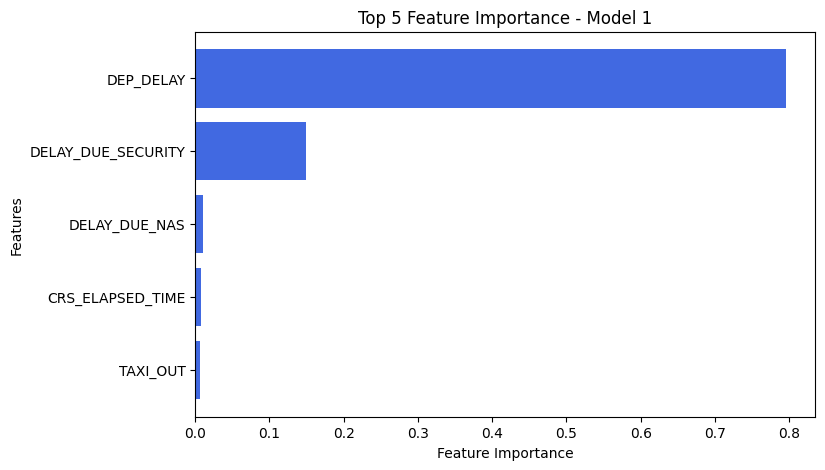


=== Top 5 Features for Model 2 ===
arr_del15: 0.7334
late_aircraft_delay: 0.2043
carrier_delay: 0.0246
nas_delay: 0.0124
nas_ct: 0.0060


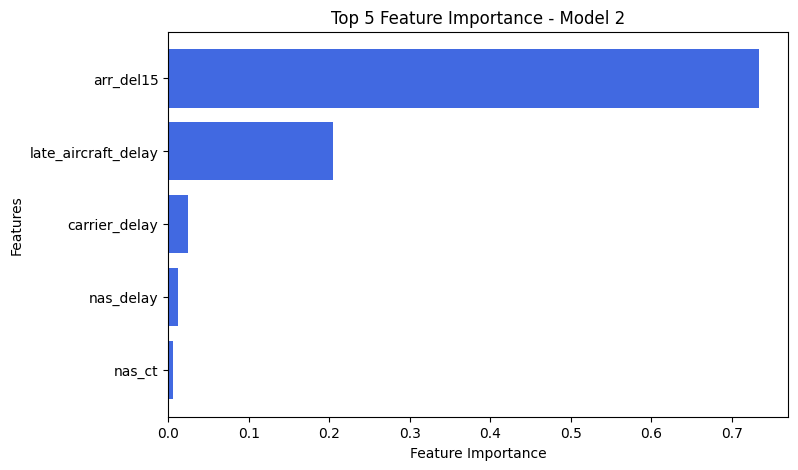


=== Top 5 Features for Model 3 ===
arr_del15: 0.7105
late_aircraft_delay: 0.2163
carrier_delay: 0.0337
late_aircraft_ct: 0.0195
nas_delay: 0.0075


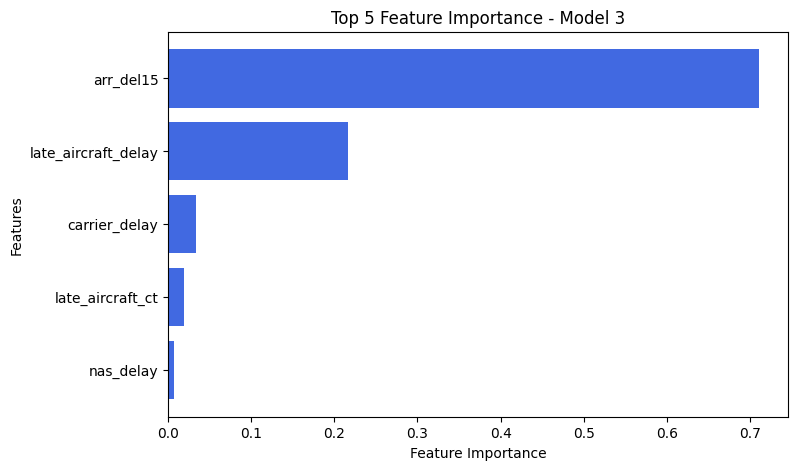


=== Top 5 Features for Model 4 ===
Distance_type_Short Haul: 0.0000
Tail_Number_N497UA: 0.0000
Tail_Number_N493WN: 0.0000
Tail_Number_N494AS: 0.0000
Tail_Number_N494CA: 0.0000


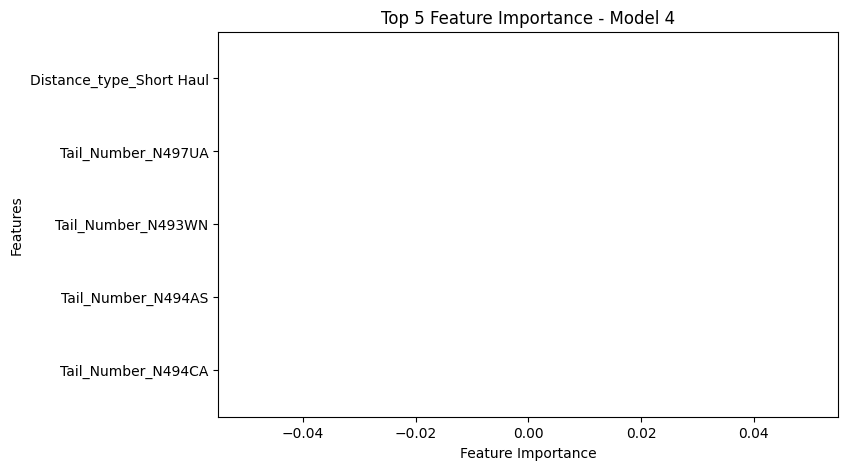

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_top_features(model, X_train, model_name):
    """Plots the top N most important features for a given model."""

    if not hasattr(model, "feature_importances_"):
        print(f"{model_name} does not support feature importance.")
        return

    # Extract feature importance
    importances = model.feature_importances_
    feature_names = np.array(X_train.columns)

    # Get the top N features
    indices = np.argsort(importances)[::-1][:5]  # Sort and take top N
    top_features = feature_names[indices]
    top_importances = importances[indices]

    # Print top N features
    print(f"\n=== Top 5 Features for {model_name} ===")
    for i in range(5):
        print(f"{top_features[i]}: {top_importances[i]:.4f}")

    # Plot top N features
    plt.figure(figsize=(8, 5))
    plt.title(f"Top 5 Feature Importance - {model_name}")
    plt.barh(top_features[::-1], top_importances[::-1], color="royalblue")
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.show()

# Run for all models
plot_top_features(rf_model_1, X_train_1, "Model 1")
plot_top_features(rf_model_2, X_train_2, "Model 2")
plot_top_features(rf_model_3, X_train_3, "Model 3")
plot_top_features(rf_model_4, X_train_4, "Model 4")


As mentioned before and we see here, the 4th model isn't providing insight. These are just some random values.<br><br>
In the <b>first</b> model, we see there's alot of importance to departure delay, and as we saw in previous exercises, the correlation between arrivale and departure delays is very high. There were also security related delays as well which contributed to arrival delays.<br>
For the <b>2nd</b> model, arrival delay of over than 15 minutes contributed too, along with late aircraft prep work and carrier (airline company) delay, who are also to blame.<br>
The same can be said on the <b>3rd</b> model (note the comments in the import phase from Drive, that the models are from the same source but different timelines).